## 1. Set up environment, load data

In [1]:
# install.packages("compositions")
# install.packages("ggdist")
library(phyloseq, verbose=F)
library(ggplot2, verbose=F)
library(compositions, verbose=F)
library(reshape2, verbose=F)
library(tidyr, verbose=F)
library(dplyr, verbose=F)
library(ggdist, verbose=F)
library(ggpubr, verbose=F)
# load in master phyloseq R data object
load("../02-diversity/master_phyloseq.RData")
# set up directory to save figures
system("mkdir img")
# check phyloseq object
ps.dat
# pull metadata table
map <- sample_data(ps.dat)

Welcome to compositions, a package for compositional data analysis.
Find an intro with "? compositions"



Attaching package: ‘compositions’


The following objects are masked from ‘package:stats’:

    anova, cor, cov, dist, var


The following object is masked from ‘package:graphics’:

    segments


The following objects are masked from ‘package:base’:

    %*%, norm, scale, scale.default


Warning message:
“package ‘tidyr’ was built under R version 4.1.3”

Attaching package: ‘tidyr’


The following object is masked from ‘package:reshape2’:

    smiths


Warning message:
“package ‘dplyr’ was built under R version 4.1.3”

Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 14111 taxa and 1960 samples ]
sample_data() Sample Data:       [ 1960 samples by 26 sample variables ]
tax_table()   Taxonomy Table:    [ 14111 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 14111 tips and 14109 internal nodes ]

## 2. Filter data to include only those teeth with multiple sampling across visits

In [2]:
map$studyID_FDI <- paste(map$study_id, ".", map$FDI_code, sep="")

Only looking at visit one to three here

In [3]:
map.v1v3 <- map[map$visit_num == 1 | map$visit_num == 3,]
# count the number of times that a study ID + FDI code appears in the data
counts <- data.frame(table(map.v1v3$studyID_FDI))
# pull records that occur more than one time
map.v1v3 <- map.v1v3[map.v1v3$studyID_FDI %in% counts$Var1[counts$Freq > 1],]
# reorder
map.v1v3 <- map.v1v3[order(map.v1v3$studyID_FDI),]
# number of samples
dim(map.v1v3)
# make sure you aren't left with singletons, this command should come back as all TRUE
# data.frame(table(map.v1v3$studyID_FDI))$Freq == 2

# get average number of days between visits
# first melt visit date column into a data frame of two columns
dates <- as.data.frame(matrix(map.v1v3$visit_date, ncol=2, byrow=TRUE))
# average difference between date of visit one and visit two
mean(as.Date(as.character(dates$V2), format="%m/%d/%Y")-as.Date(as.character(dates$V1), format="%m/%d/%Y"))

[1] 408  27

Time difference of 400.701 days

## 3. Volatility analyses

Because we have the full range of analyses in the other notebook (volatility.ipynb), only focus on the figures and analyses we want to add in the paper here

### 3.1 All teeth over visit one and three

In [4]:
counts <- otu_table(ps.dat)[row.names(map.v1v3),]
dim(counts)
# remove asvs with zero count after filtering
counts <- counts[,colSums(counts) > 0]
dim(counts)

# make sure data is all numeric
counts <- apply(counts,c(1,2),function(x) as.numeric(as.character(x)))
# perform clr transformation to the data
counts.clr <- clr(counts)
# distance
counts.dist <- dist(counts.clr, method="euclidean")
# pca
counts.pca <- prcomp(counts.dist)
# extract the amount of variance for first four components
pc1 <- round(counts.pca$sdev[1]^2/sum(counts.pca$sdev^2),4) * 100
pc2 <- round(counts.pca$sdev[2]^2/sum(counts.pca$sdev^2),4) * 100
pc3 <- round(counts.pca$sdev[3]^2/sum(counts.pca$sdev^2),4) * 100
pc4 <- round(counts.pca$sdev[4]^2/sum(counts.pca$sdev^2),4) * 100

# extract scores for each sample for first four components
pca <- data.frame(PC1 = counts.pca$x[,1],
                  PC2 = counts.pca$x[,2],
                  PC3 = counts.pca$x[,3],
                  PC4 = counts.pca$x[,4])
# add metadata to the pca scores
pca$studyID_FDI <- map.v1v3$studyID_FDI # individual tooth identifier
pca$hiv_status <- map.v1v3$hiv_status # cohort to split frames
pca$hiv_status <- factor(pca$hiv_status, levels=c("HI", "HEU", "HUU"))
pca$tooth_health <- map.v1v3$tooth_health # treatment
pca$visit_num <- map.v1v3$visit_num # time point data

[1]   408 14111

[1]   408 10945

png 
  2

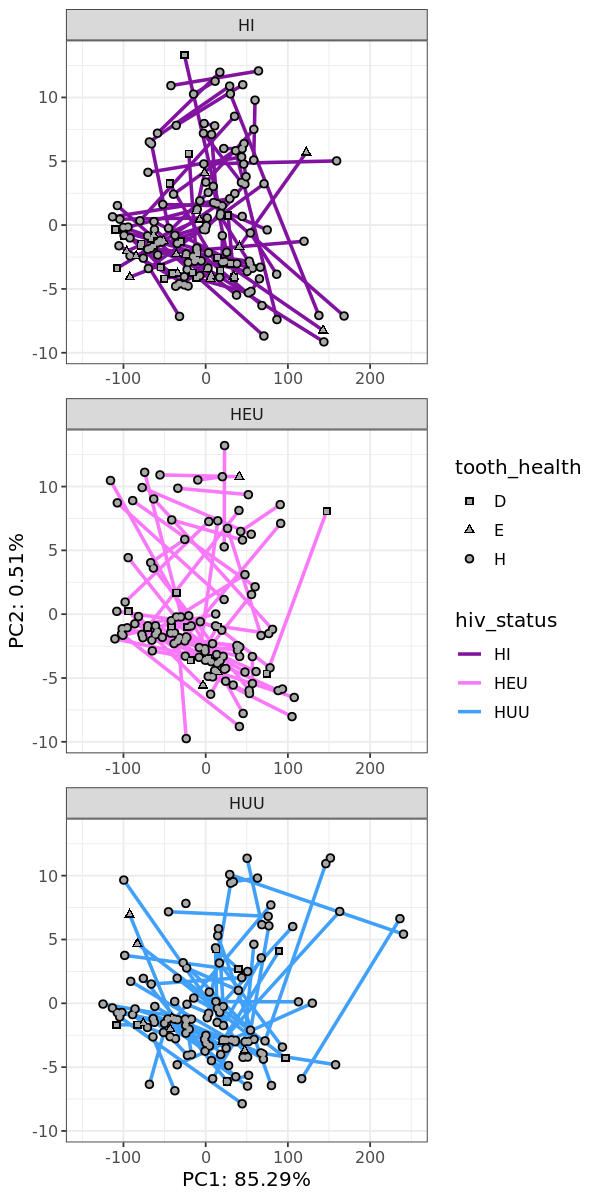

In [5]:
# spread out so we can see x axis more  
options(repr.plot.width = 5, repr.plot.height =10)

# Plot!
pdf("img/volplot.pca.v1v3.pdf", width=5, height=10)
ggplot(pca, aes(x = PC1,
                y = PC2,
                colour = hiv_status,
                shape = tooth_health,
                group = studyID_FDI)) +  
geom_line(lwd=1) +
geom_point(size = 2, col="black") +
geom_point(size = 1, col="dark grey") +
scale_shape_manual(values=c(15,17,19)) +
facet_wrap(~hiv_status, scales = "free_x", ncol=1) +
scale_fill_manual(values=c("HI"="#8213A0", "HEU"="#FA78FA", "HUU"="#40A0FA")) +
scale_colour_manual(values=c("HI"="#8213A0", "HEU"="#FA78FA", "HUU"="#40A0FA")) +
theme_bw() +
xlab(paste("PC1: ", pc1,  "%", sep="")) +
ylab(paste("PC2: ", pc2,  "%", sep="")) +
theme(text = element_text(size = 12)) +
xlim(-150,250) +
guides(fill = guide_legend(override.aes = list(shape = 22)))
dev.off()

ggplot(pca, aes(x = PC1,
                y = PC2,
                colour = hiv_status,
                shape = tooth_health,
                group = studyID_FDI)) +  
geom_line(lwd=1) +
geom_point(size = 2, col="black") +
geom_point(size = 1, col="dark grey") +
scale_shape_manual(values=c(15,17,19)) +
facet_wrap(~hiv_status, scales = "free_x", ncol=1) +
scale_fill_manual(values=c("HI"="#8213A0", "HEU"="#FA78FA", "HUU"="#40A0FA")) +
scale_colour_manual(values=c("HI"="#8213A0", "HEU"="#FA78FA", "HUU"="#40A0FA")) +
theme_bw() +
xlab(paste("PC1: ", pc1,  "%", sep="")) +
ylab(paste("PC2: ", pc2,  "%", sep="")) +
theme(text = element_text(size = 12)) +
xlim(-150,250) +
guides(fill = guide_legend(override.aes = list(shape = 22)))

In [6]:
# compute volatility -- euclidean distance over CLR transformed count data (aitchison distance between pairs)
# first need to melt our distance matrix to get pairs of samples and their distance
counts.melt <- melt(as.matrix(counts.dist))
# modify sample names in columns
counts.melt$Var1 <- gsub("V.*PQ", ".", counts.melt$Var1)
counts.melt$Var2 <- gsub("V.*PQ", ".", counts.melt$Var2)
# clean up data
counts.melt <- counts.melt[counts.melt$value != 0, ]
counts.melt$match <- ifelse(counts.melt$Var1 == counts.melt$Var2, "TRUE", "FALSE")
# get only those that are duplicated samples, clean up again
matches <- counts.melt[counts.melt$match == "TRUE",]
matches <- as.data.frame(matches[,-2])
matches <- matches[!duplicated(matches),]

# get temporary metadata file to merge in with your distance metrics
temp <- as.data.frame(cbind(map.v1v3$studyID_FDI, map.v1v3$hiv_status))
temp <- temp[!duplicated(temp),]
# final dataframe
dist_diff <- merge(x=matches, y=temp, by.x="Var1", by.y="V1")

# some summary statistics on these distances
group_by(dist_diff, V2) %>%
  summarise(
    count = n(),
    median = median(value, na.rm = TRUE),
    SD = sd(value, na.rm = TRUE)
)

V2,count,median,SD
<chr>,<int>,<dbl>,<dbl>
HEU,59,21.98312,3.097594
HI,74,22.26461,4.259307
HUU,63,23.50762,4.919513


png 
  2

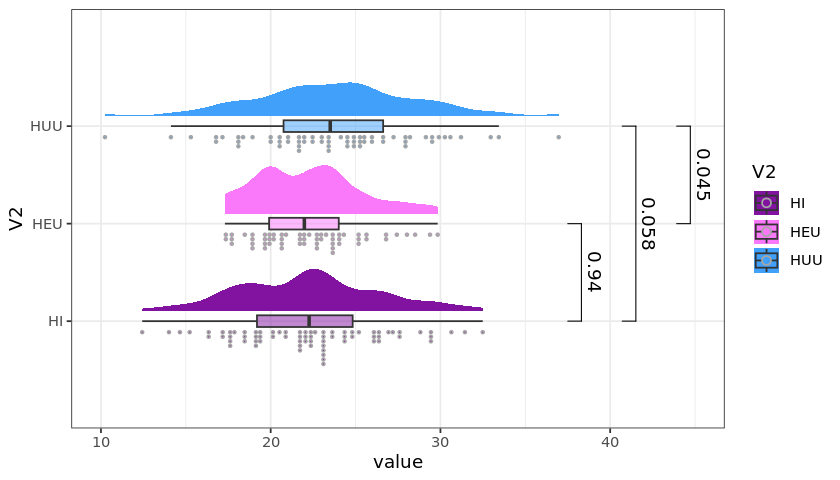

In [7]:
# boxplots
dist_diff$V2 <- factor(dist_diff$V2, levels=c("HI", "HEU", "HUU"))

pdf("img/volatility.bplot.v1v3.pdf")
options(repr.plot.width = 7, repr.plot.height =5)
ggplot(dist_diff, aes(x=V2, y=value, fill=V2)) + 
    geom_pwc(label = "{p.adj.format}", hide.ns =FALSE, method = "wilcox_test", p.adjust.method = "none") +
    theme_bw() +
    stat_halfeye(adjust = 0.5, justification = -0.2, .width = 0, point_colour = NA, normalize="all", scale=0.5) + 
    geom_boxplot(width = 0.12, alpha = 0.5, outlier.color=NA) +
    stat_dots(side = "left", justification = 1.1, binwidth = 0.25) +
    scale_fill_manual(values=c("HI"="#8213A0", "HEU"="#FA78FA", "HUU"="#40A0FA")) +
    scale_colour_manual(values=c("HI"="#8213A0", "HEU"="#FA78FA", "HUU"="#40A0FA")) +
    scale_y_continuous(limits=c(10,45)) +
    coord_flip()
dev.off()

options(repr.plot.width = 7, repr.plot.height = 4)
ggplot(dist_diff, aes(x=V2, y=value, fill=V2)) + 
    geom_pwc(label = "{p.adj.format}", hide.ns =FALSE, method = "wilcox_test", p.adjust.method = "none") +
    theme_bw() +
    stat_halfeye(adjust = 0.5, justification = -0.2, .width = 0, point_colour = NA, normalize="all", scale=0.5) + 
    geom_boxplot(width = 0.12, alpha = 0.5, outlier.color=NA) +
    stat_dots(side = "left", justification = 1.1, binwidth = 0.25) +
    scale_fill_manual(values=c("HI"="#8213A0", "HEU"="#FA78FA", "HUU"="#40A0FA")) +
    scale_colour_manual(values=c("HI"="#8213A0", "HEU"="#FA78FA", "HUU"="#40A0FA")) +
    scale_y_continuous(limits=c(10,45)) +
    coord_flip()

### 3.2 Only healthy (H) teeth visit one vs visit three

png 
  2

V2,count,median,SD
<chr>,<int>,<dbl>,<dbl>
HEU,52,22.45735,3.056431
HI,53,22.27747,3.908752
HUU,54,23.46366,4.522158


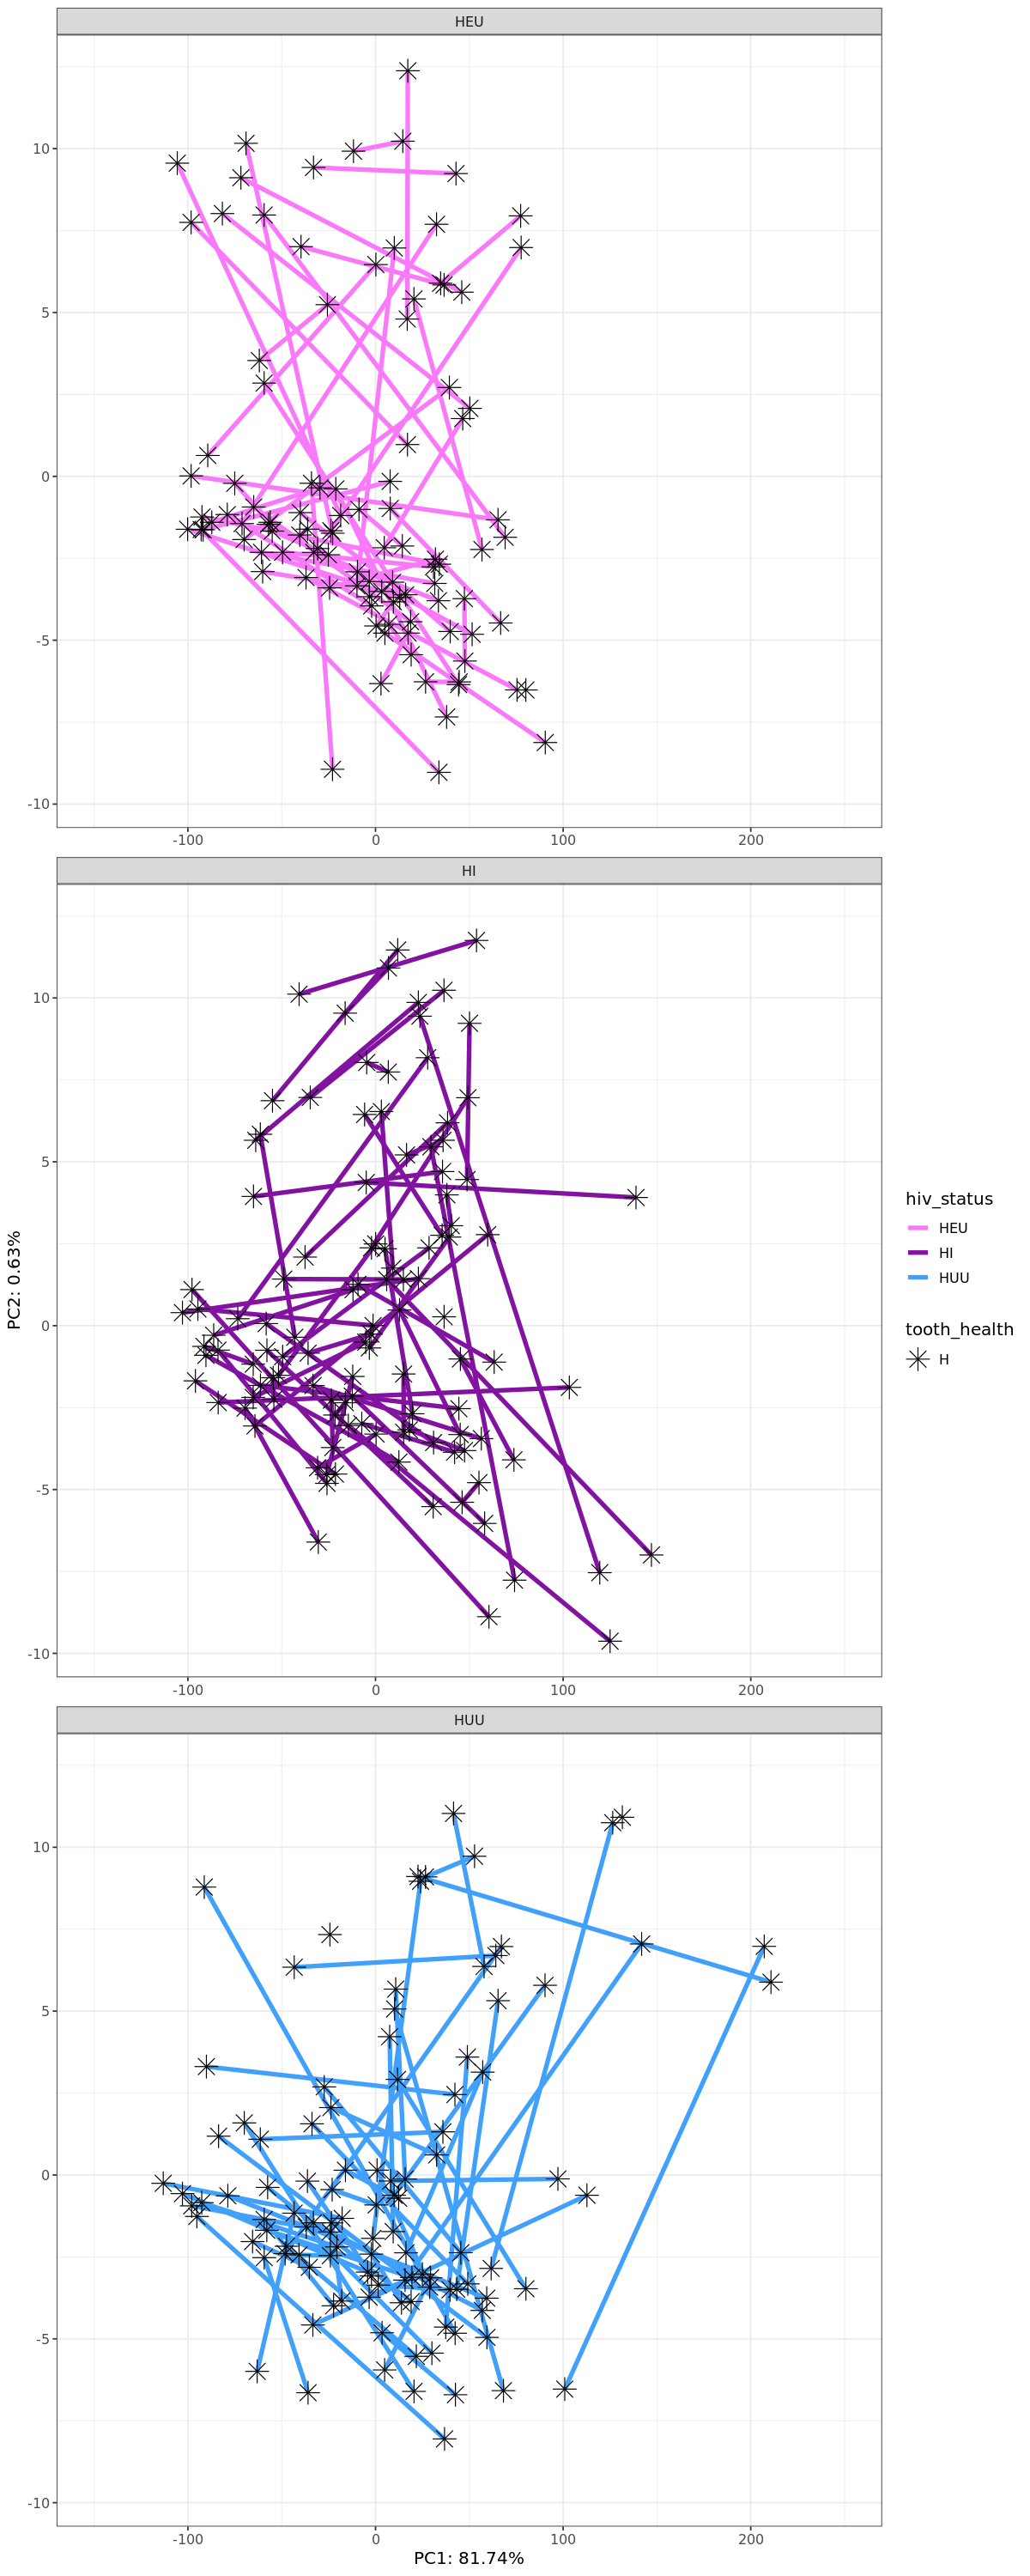

In [8]:
# first filter so that we are only looking at healthy teeth in our phyloseq object
ps.dat.h <- subset_samples(ps.dat, tooth_health=="H")
# pull metadata table
map <- sample_data(ps.dat.h)
# this should look similar to the processing steps above. Basically want to create a new ASV table with duplicate samples across visit one and visit three
map$studyID_FDI <- paste(map$study_id, ".", map$FDI_code, sep="")
map.v1v3 <- map[map$visit_num == 1 | map$visit_num == 3,]
counts <- data.frame(table(map.v1v3$studyID_FDI))
map.v1v3 <- map.v1v3[map.v1v3$studyID_FDI %in% counts$Var1[counts$Freq > 1],]
map.v1v3 <- map.v1v3[order(map.v1v3$studyID_FDI),]
counts <- otu_table(ps.dat)[row.names(map.v1v3),]
counts <- counts[,colSums(counts) > 0]
counts <- apply(counts,c(1,2),function(x) as.numeric(as.character(x)))
# perform clr transformation to the data
counts.clr <- clr(counts)
# distance
counts.dist <- dist(counts.clr, method="euclidean")
# pca
counts.pca <- prcomp(counts.dist)
# extract the amount of variance for first four components
pc1 <- round(counts.pca$sdev[1]^2/sum(counts.pca$sdev^2),4) * 100
pc2 <- round(counts.pca$sdev[2]^2/sum(counts.pca$sdev^2),4) * 100
pc3 <- round(counts.pca$sdev[3]^2/sum(counts.pca$sdev^2),4) * 100
pc4 <- round(counts.pca$sdev[4]^2/sum(counts.pca$sdev^2),4) * 100

# extract scores for each sample for first four components
pca <- data.frame(PC1 = counts.pca$x[,1],
                  PC2 = counts.pca$x[,2],
                  PC3 = counts.pca$x[,3],
                  PC4 = counts.pca$x[,4])

# add metadata to the pca scores
pca$studyID_FDI <- map.v1v3$studyID_FDI # individual tooth identifier
pca$hiv_status <- map.v1v3$hiv_status # cohort to split frames
pca$tooth_health <- map.v1v3$tooth_health # treatment
pca$visit_num <- map.v1v3$visit_num # time point data

# spread out so we can see x axis more than 
options(repr.plot.width = 10, repr.plot.height =25)
                
pdf("img/volplot.pca.v1v3.H.pdf")
ggplot(pca, aes(x = PC1,
                y = PC2,
                colour = hiv_status,
                shape = tooth_health,
                group = studyID_FDI)) +  
geom_line(lwd=1.5) +
geom_point(size = 5, col="black") +
scale_shape_manual(values=c(8,17,19)) +
facet_wrap(~hiv_status, scales = "free_x", ncol=1) +
scale_fill_manual(values=c("HI"="#8213A0", "HEU"="#FA78FA", "HUU"="#40A0FA")) +
scale_colour_manual(values=c("HI"="#8213A0", "HEU"="#FA78FA", "HUU"="#40A0FA")) +
theme_bw() +
xlab(paste("PC1: ", pc1,  "%", sep="")) +
ylab(paste("PC2: ", pc2,  "%", sep="")) +
theme(text = element_text(size = 12)) +
xlim(-150,250) +
guides(fill = guide_legend(override.aes = list(shape = 22)))
dev.off()
                
ggplot(pca, aes(x = PC1,
                y = PC2,
                colour = hiv_status,
                shape = tooth_health,
                group = studyID_FDI)) +  
geom_line(lwd=1.5) +
geom_point(size = 5, col="black") +
scale_shape_manual(values=c(8,17,19)) +
facet_wrap(~hiv_status, scales = "free_x", ncol=1) +
scale_fill_manual(values=c("HI"="#8213A0", "HEU"="#FA78FA", "HUU"="#40A0FA")) +
scale_colour_manual(values=c("HI"="#8213A0", "HEU"="#FA78FA", "HUU"="#40A0FA")) +
theme_bw() +
xlab(paste("PC1: ", pc1,  "%", sep="")) +
ylab(paste("PC2: ", pc2,  "%", sep="")) +
theme(text = element_text(size = 12)) +
xlim(-150,250) +
guides(fill = guide_legend(override.aes = list(shape = 22)))
                
# compute volatility -- euclidean distance over CLR transformed count data (aitchison distance between pairs)
# first need to melt our distance matrix to get pairs of samples and their distance
counts.melt <- melt(as.matrix(counts.dist))
# modify sample names in columns
counts.melt$Var1 <- gsub("V.*PQ", ".", counts.melt$Var1)
counts.melt$Var2 <- gsub("V.*PQ", ".", counts.melt$Var2)
# clean up data
counts.melt <- counts.melt[counts.melt$value != 0, ]
counts.melt$match <- ifelse(counts.melt$Var1 == counts.melt$Var2, "TRUE", "FALSE")
# get only those that are duplicated samples, clean up again
matches <- counts.melt[counts.melt$match == "TRUE",]
matches <- as.data.frame(matches[,-2])
matches <- matches[!duplicated(matches),]

# get temporary metadata file to merge in with your distance metrics
temp <- as.data.frame(cbind(map.v1v3$studyID_FDI, map.v1v3$hiv_status))
temp <- temp[!duplicated(temp),]
# final dataframe
dist_diff <- merge(x=matches, y=temp, by.x="Var1", by.y="V1")

# some summary statistics on these distances
group_by(dist_diff, V2) %>%
  summarise(
    count = n(),
    median = median(value, na.rm = TRUE),
    SD = sd(value, na.rm = TRUE)
)

png 
  2

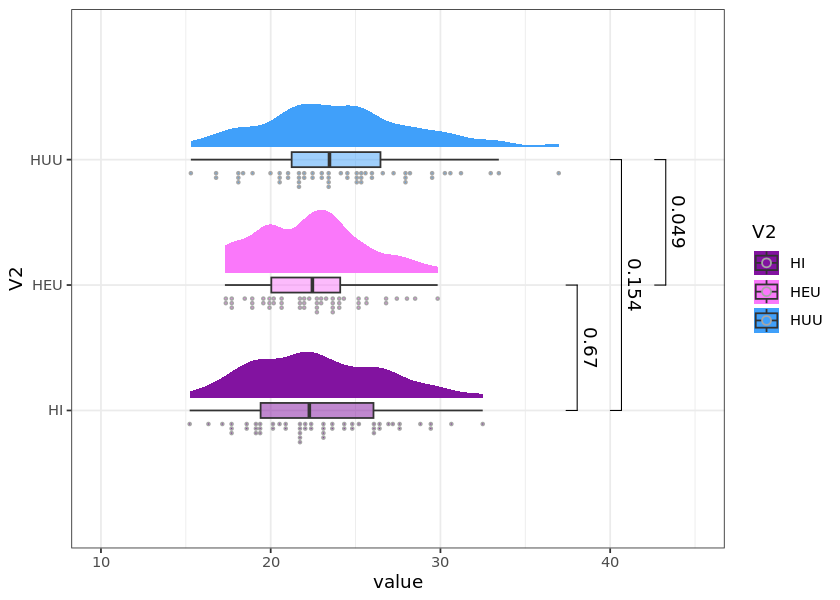

In [9]:
# boxplots
dist_diff$V2 <- factor(dist_diff$V2, levels=c("HI", "HEU", "HUU"))
options(repr.plot.width = 7, repr.plot.height =5)

pdf("img/volatility.bplot.v1v3.H.pdf")
ggplot(dist_diff, aes(x=V2, y=value, fill=V2)) + 
    geom_pwc(label = "{p.adj.format}", hide.ns =FALSE, method = "wilcox_test", p.adjust.method = "none") +
    theme_bw() +
    stat_halfeye(adjust = 0.5, justification = -0.2, .width = 0, point_colour = NA, normalize="all", scale=0.5) + 
    geom_boxplot(width = 0.12, alpha = 0.5, outlier.color=NA) +
    stat_dots(side = "left", justification = 1.1, binwidth = 0.25) +
    scale_fill_manual(values=c("HI"="#8213A0", "HEU"="#FA78FA", "HUU"="#40A0FA")) +
    scale_colour_manual(values=c("HI"="#8213A0", "HEU"="#FA78FA", "HUU"="#40A0FA")) +
    scale_y_continuous(limits=c(10,45)) +
    coord_flip()
dev.off()

ggplot(dist_diff, aes(x=V2, y=value, fill=V2)) + 
    geom_pwc(label = "{p.adj.format}", hide.ns =FALSE, method = "wilcox_test", p.adjust.method = "none") +
    theme_bw() +
    stat_halfeye(adjust = 0.5, justification = -0.2, .width = 0, point_colour = NA, normalize="all", scale=0.5) + 
    geom_boxplot(width = 0.12, alpha = 0.5, outlier.color=NA) +
    stat_dots(side = "left", justification = 1.1, binwidth = 0.25) +
    scale_fill_manual(values=c("HI"="#8213A0", "HEU"="#FA78FA", "HUU"="#40A0FA")) +
    scale_colour_manual(values=c("HI"="#8213A0", "HEU"="#FA78FA", "HUU"="#40A0FA")) +
    scale_y_continuous(limits=c(10,45)) +
    coord_flip()

In [30]:
# collapse data to roughly species level to minimize high sparsity
ps.dat.L7 <- tax_glom(ps.dat, taxrank=rank_names(ps.dat)[7])

In [53]:
# save copy to reduce time on previous command
glom <- ps.dat.L7
# remove any taxa with fewer than 500 counts and in at least 1% of samples post merging 
glom <- filter_taxa(glom, function(x) sum(x > 500) > (0.01*length(x)), TRUE)

In [54]:
glom

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 155 taxa and 1960 samples ]
sample_data() Sample Data:       [ 1960 samples by 26 sample variables ]
tax_table()   Taxonomy Table:    [ 155 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 155 tips and 154 internal nodes ]

In [55]:
# pull data
dat <- as.data.frame(otu_table(glom))
map <- as.data.frame(as.matrix(sample_data(glom))) # have to coerce to data frame
map <- tibble::rownames_to_column(map) # retain rownames for downstream processing

In [56]:
# first need to get comparable variable to merge our data on
# head(dist_diff)
map$Var1 <- paste(map$study_id, map$FDI_code, sep=".")
# head(map)
# head(dist_diff)
# merge dist_diff with map
map <- merge(as.data.frame(map), dist_diff, by="Var1")

In [57]:
# merge new metadata with asv table so the response variable is in the same order
datmerge <- merge(dat, map, by.x = "row.names", by.y = "rowname")

In [58]:
datmerge <- datmerge[!duplicated(datmerge[c('Row.names')]), ]
row.names(datmerge) <- datmerge$Row.names

In [59]:
# define data and response variable
dif <- dim(datmerge)[2] - dim(map)[2]
x <- datmerge[,2:dif]
# make sure only numeric data
# x <- select_if(x, is.numeric)
# dim(x)
# define response variable 
y <- datmerge$value

In [60]:
# install.packages("coda4microbiome")
library(coda4microbiome)

In [61]:
x <- as.matrix(x) # ASV abundance table
x_time <- as.numeric(datmerge$visit_num) # time point
subject_id <- datmerge$study_id # subject id
y <- datmerge$value # response value (here is volatility)
ini_time <- 1
end_time <- 3
set.seed(852)

In [62]:
bal <- coda_glmnet_longitudinal(x, y, x_time, subject_id, ini_time, end_time, nfolds=10, showPlots = FALSE)

[1] "ind= 1"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 2"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 3"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 4"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 5"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 6"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 7"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 8"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 9"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 10"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 11"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 12"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 13"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 14"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 15"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 16"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 17"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 18"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 19"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 20"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 21"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 22"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 23"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 24"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 25"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 26"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 27"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 28"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 29"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 30"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 31"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 32"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 33"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 34"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 35"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 36"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 37"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 38"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 39"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 40"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 41"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 42"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 43"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 44"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 45"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 46"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 47"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 48"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 49"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 50"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 51"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 52"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 53"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 54"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 55"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 56"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 57"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 58"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 59"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 60"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 61"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 62"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 63"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 64"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 65"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 66"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 67"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 68"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 69"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 70"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 71"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 72"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 73"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 74"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 75"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 76"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 77"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 78"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 79"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 80"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 81"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 82"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 83"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 84"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 85"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 86"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 87"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 88"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 89"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 90"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 91"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 92"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 93"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 94"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 95"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 96"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 97"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 98"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 99"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 100"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 101"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 102"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 103"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 104"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 105"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 106"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 107"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 108"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 109"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 110"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 111"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 112"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 113"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 114"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 115"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 116"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 117"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 118"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 119"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 120"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 121"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 122"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 123"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 124"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 125"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 126"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 127"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 128"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 129"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 130"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 131"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 132"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 133"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 134"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 135"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 136"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 137"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 138"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 139"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 140"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 141"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 142"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 143"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 144"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 145"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 146"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 147"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 148"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 149"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 150"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 151"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 152"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 153"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 154"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] 157 154


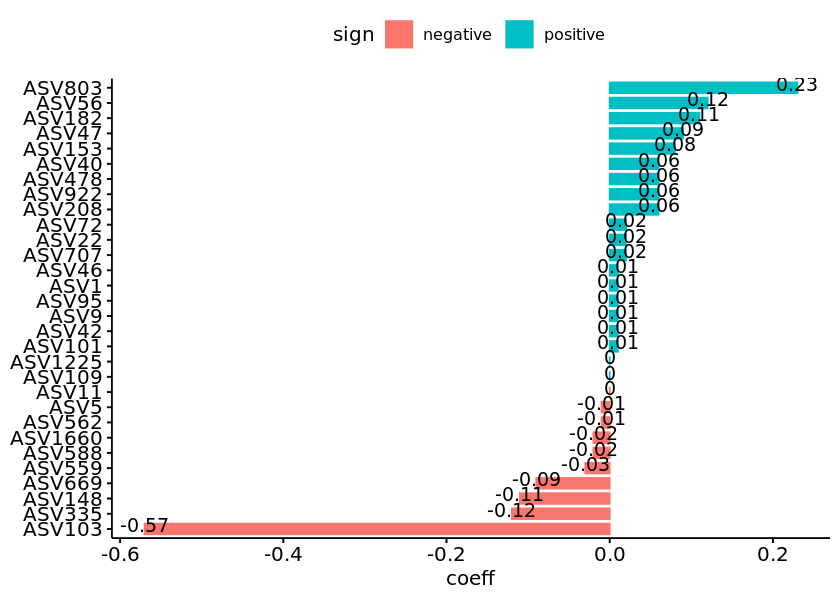

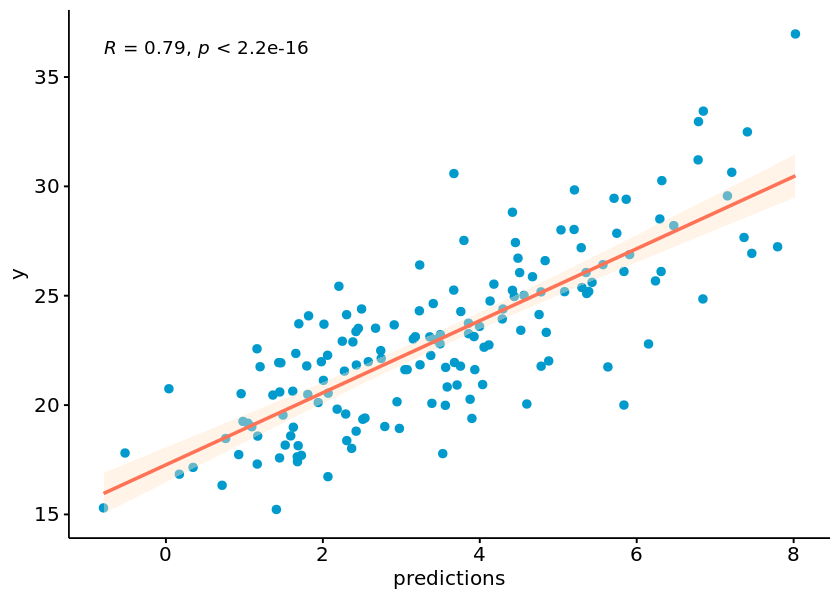

In [63]:
coef <- bal$`log-contrast coefficients`
positives <- which(coef>=0)
op <- order(coef[positives], decreasing = TRUE)
bal$`signature plot`
bal$`predictions plot`

In [64]:
pdf("img/volatility_microbial_signature.pdf")
bal$`signature plot`
bal$`predictions plot`
dev.off()

png 
  2

In [65]:
temp <- bal$`predictions plot`

In [93]:
# so I want to color the points in our predictions graph by what HIV status group they are for the figure -- first need to concatenate the metadata with the data frame output by coda4microbiome
# keeping the y values here for sanity check purposes
temp.cat <- cbind(temp$data, unique(subject_id), unique(y))
# head(temp.cat)
# colnames(datmerge)
# now merge by subject id to get HIV status group
merged.dat <- merge(temp.cat, datmerge, by.x = "unique(subject_id)", by.y = "study_id")
# head(merged.dat)
# have to rebuild the dataframe to only inlclude prediction, y, and hiv status so we can unique the prediction/y values
uniq.dat <- as.data.frame(unique(cbind(merged.dat$predictions, merged.dat$y, merged.dat$hiv_status)))
head(uniq.dat)

,V1,V2,V3
,<chr>,<chr>,<chr>
1,1.65539142727265,22.3614284809837,HUU
2,4.48690020915486,26.7172721934078,HEU
3,3.67015624471825,30.586642279683,HUU
4,6.78743321951616,32.9626870509299,HUU
5,3.66820471055254,25.2569859979471,HEU
6,5.20629485346564,29.8373111479371,HEU


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


png 
  2

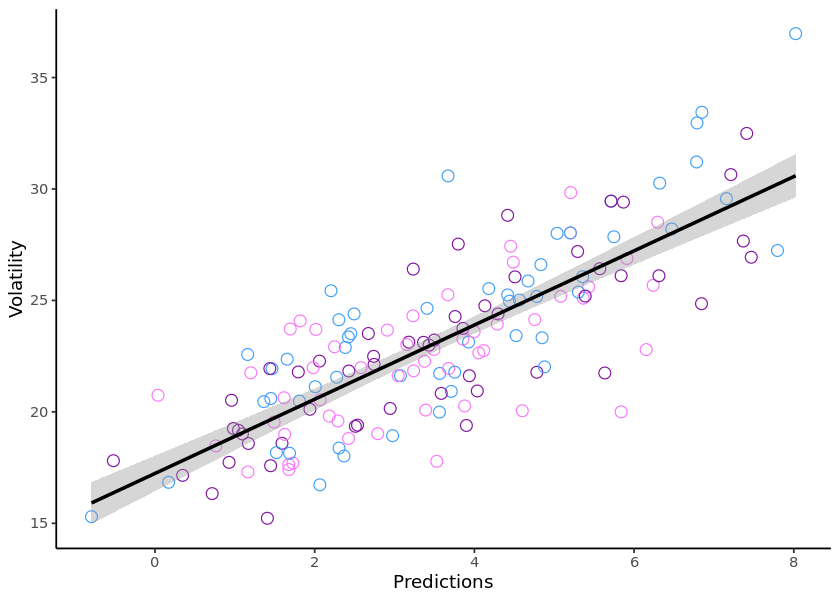

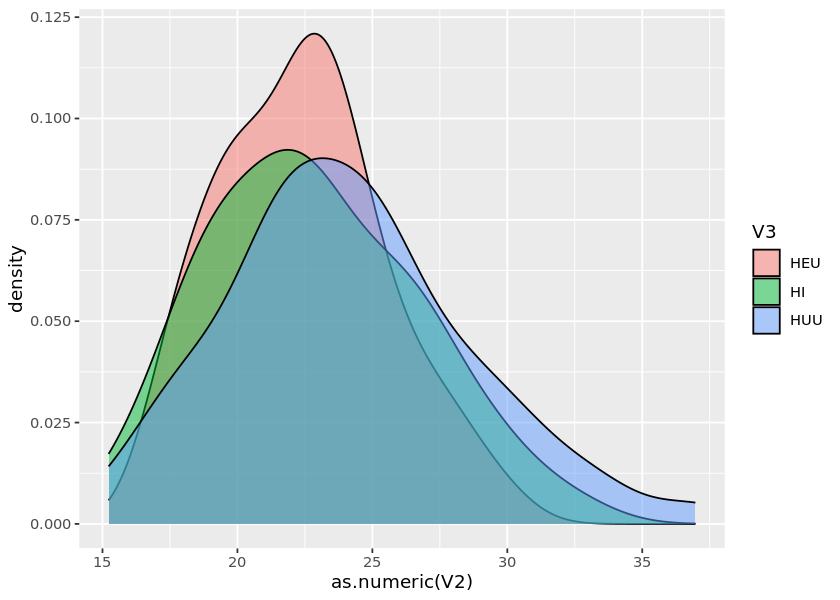

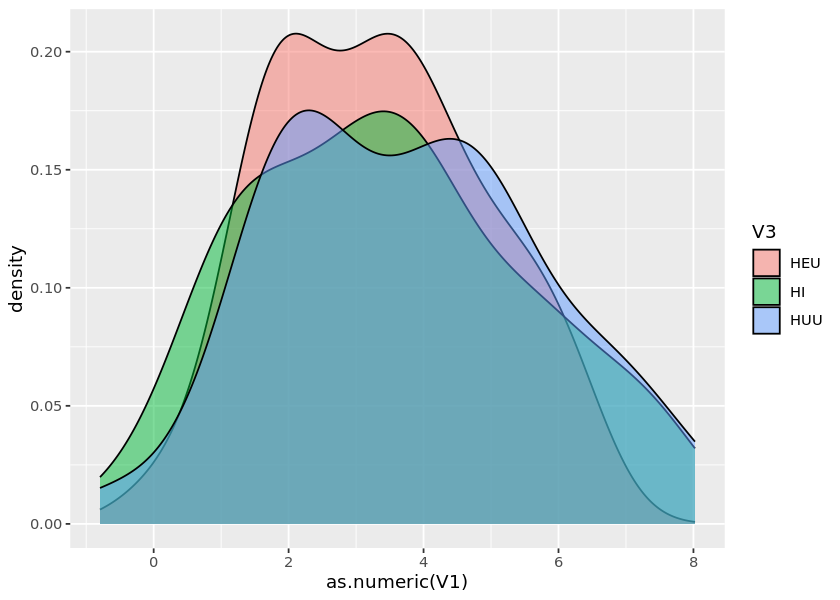

In [112]:
# now can remake the predictions correlation plot but color by hiv status
p <- ggplot(uniq.dat, aes(x=as.numeric(V1), y=as.numeric(V2), color=V3)) + 
    geom_point(size = 3, pch=21) + 
    theme_classic() +
    geom_smooth(method="lm", color="black") +
    scale_color_manual(values=c("HI"="#8213A0", "HEU"="#FA78FA", "HUU"="#40A0FA")) +
    theme(legend.position="none") +
    xlab("Predictions") +
    ylab("Volatility")
p
pdf("img/volatility_microbial_signature.clean.pdf")
p
dev.off()
# distribution of both axes just for vizualization
ggplot(uniq.dat, aes(x=as.numeric(V2), fill=V3)) + 
    geom_density(alpha=0.5)
ggplot(uniq.dat, aes(x=as.numeric(V1), fill=V3)) + 
    geom_density(alpha=0.5)

In [43]:
# taxa that are driving volatility in HI?
glom <- ps.dat.L7
glom <- subset_samples(glom, hiv_status == "HI")
glom <- filter_taxa(glom, function(x) sum(x > 500) > (0.01*length(x)), TRUE)

In [44]:
glom

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 159 taxa and 735 samples ]
sample_data() Sample Data:       [ 735 samples by 26 sample variables ]
tax_table()   Taxonomy Table:    [ 159 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 159 tips and 158 internal nodes ]

In [45]:
# pull data
dat <- as.data.frame(otu_table(glom))
map <- as.data.frame(as.matrix(sample_data(glom))) # have to coerce to data frame
map <- tibble::rownames_to_column(map) # retain rownames for downstream processing
# first need to get comparable variable to merge our data on
# head(dist_diff)
map$Var1 <- paste(map$study_id, map$FDI_code, sep=".")
# head(map)
# head(dist_diff)
# merge dist_diff with map
map <- merge(as.data.frame(map), dist_diff, by="Var1")
# merge new metadata with asv table so the response variable is in the same order
datmerge <- merge(dat, map, by.x = "row.names", by.y = "rowname")
datmerge <- datmerge[!duplicated(datmerge[c('Row.names')]), ]
row.names(datmerge) <- datmerge$Row.names
# define data and response variable
dif <- dim(datmerge)[2] - dim(map)[2]
x <- datmerge[,2:dif]
# make sure only numeric data
# x <- select_if(x, is.numeric)
# dim(x)
x <- as.matrix(x) # ASV abundance table
x_time <- as.numeric(datmerge$visit_num) # time point
subject_id <- datmerge$study_id # subject id
y <- datmerge$value # response value (here is volatility)
ini_time <- 1
end_time <- 3
set.seed(852)

In [46]:
length(y)
dim(x)

[1] 126

[1] 126 158

In [47]:
bal <- coda_glmnet_longitudinal(x, y, x_time, subject_id, ini_time, end_time, nfolds=10, showPlots = FALSE)

[1] "ind= 1"
[1] "ind= 2"
[1] "ind= 3"
[1] "ind= 4"
[1] "ind= 5"
[1] "ind= 6"
[1] "ind= 7"
[1] "ind= 8"
[1] "ind= 9"
[1] "ind= 10"
[1] "ind= 11"
[1] "ind= 12"
[1] "ind= 13"
[1] "ind= 14"
[1] "ind= 15"
[1] "ind= 16"
[1] "ind= 17"
[1] "ind= 18"
[1] "ind= 19"
[1] "ind= 20"
[1] "ind= 21"
[1] "ind= 22"
[1] "ind= 23"
[1] "ind= 24"
[1] "ind= 25"
[1] "ind= 26"
[1] "ind= 27"
[1] "ind= 28"
[1] "ind= 29"
[1] "ind= 30"
[1] "ind= 31"
[1] "ind= 32"
[1] "ind= 33"
[1] "ind= 34"
[1] "ind= 35"
[1] "ind= 36"
[1] "ind= 37"
[1] "ind= 38"
[1] "ind= 39"
[1] "ind= 40"
[1] "ind= 41"
[1] "ind= 42"
[1] "ind= 43"
[1] "ind= 44"
[1] "ind= 45"
[1] "ind= 46"
[1] "ind= 47"
[1] "ind= 48"
[1] "ind= 49"
[1] "ind= 50"
[1] "ind= 51"
[1] "ind= 52"
[1] "ind= 53"
[1] "ind= 54"
[1] "ind= 55"
[1] "ind= 56"
[1] "ind= 57"
[1] "ind= 58"
[1] "ind= 59"
[1] "ind= 60"
[1] "ind= 61"
[1] "ind= 62"
[1] "ind= 63"
[1] "ind= 64"
[1] "ind= 65"
[1] "ind= 66"
[1] "ind= 67"
[1] "ind= 68"
[1] "ind= 69"
[1] "ind= 70"
[1] "ind= 71"
[1] "ind= 72"
[

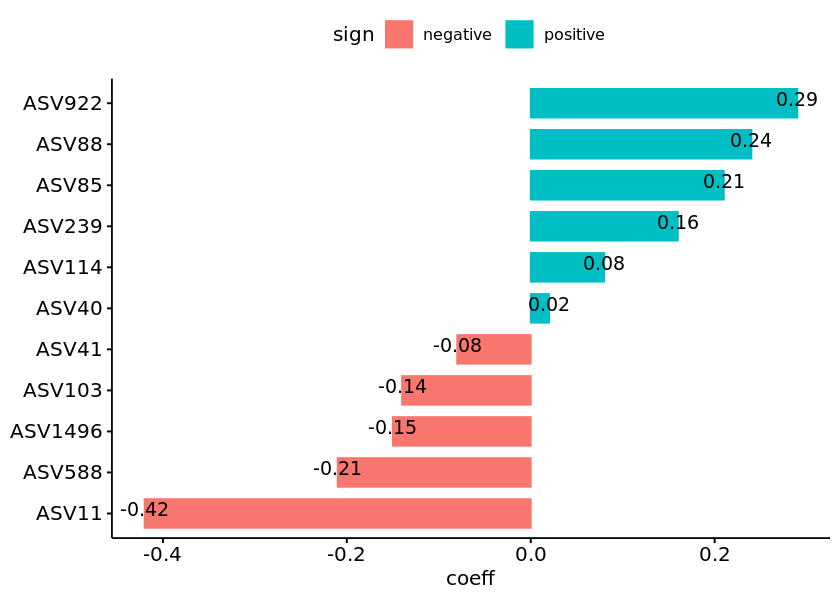

png 
  2

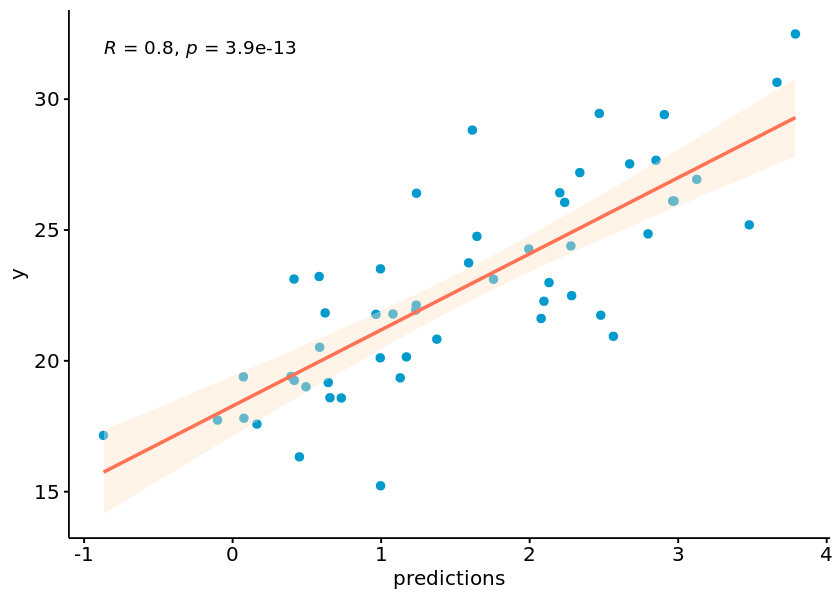

In [48]:
bal$`signature plot`
bal$`predictions plot`
pdf("img/volatility_microbial_signature.HI.pdf")
bal$`signature plot`
bal$`predictions plot`
dev.off()

In [49]:
# taxa that are driving volatility in HUU?
glom <- ps.dat.L7
glom <- subset_samples(glom, hiv_status == "HUU")
glom <- filter_taxa(glom, function(x) sum(x > 500) > (0.01*length(x)), TRUE)
# pull data
dat <- as.data.frame(otu_table(glom))
map <- as.data.frame(as.matrix(sample_data(glom))) # have to coerce to data frame
map <- tibble::rownames_to_column(map) # retain rownames for downstream processing
# first need to get comparable variable to merge our data on
# head(dist_diff)
map$Var1 <- paste(map$study_id, map$FDI_code, sep=".")
# head(map)
# head(dist_diff)
# merge dist_diff with map
map <- merge(as.data.frame(map), dist_diff, by="Var1")
# merge new metadata with asv table so the response variable is in the same order
datmerge <- merge(dat, map, by.x = "row.names", by.y = "rowname")
datmerge <- datmerge[!duplicated(datmerge[c('Row.names')]), ]
row.names(datmerge) <- datmerge$Row.names
# define data and response variable
dif <- dim(datmerge)[2] - dim(map)[2]
x <- datmerge[,2:dif]
# make sure only numeric data
# x <- select_if(x, is.numeric)
# dim(x)
x <- as.matrix(x) # ASV abundance table
x_time <- as.numeric(datmerge$visit_num) # time point
subject_id <- datmerge$study_id # subject id
y <- datmerge$value # response value (here is volatility)
ini_time <- 1
end_time <- 3
set.seed(852)
bal <- coda_glmnet_longitudinal(x, y, x_time, subject_id, ini_time, end_time, nfolds=10, showPlots = FALSE)

[1] "ind= 1"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 2"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 3"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 4"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 5"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 6"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 7"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 8"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 9"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 10"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 11"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 12"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 13"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 14"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 15"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 16"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 17"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 18"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 19"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 20"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 21"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 22"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 23"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 24"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 25"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 26"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 27"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 28"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 29"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 30"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 31"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 32"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 33"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 34"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 35"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 36"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 37"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 38"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 39"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 40"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 41"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 42"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 43"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 44"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 45"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 46"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 47"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 48"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 49"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 50"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 51"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 52"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 53"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 54"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 55"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 56"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 57"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 58"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 59"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 60"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 61"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 62"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 63"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 64"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 65"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 66"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 67"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 68"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 69"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 70"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 71"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 72"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 73"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 74"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 75"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 76"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 77"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 78"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 79"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 80"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 81"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 82"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 83"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 84"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 85"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 86"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 87"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 88"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 89"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 90"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 91"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 92"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 93"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 94"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 95"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 96"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 97"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 98"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 99"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 100"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 101"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 102"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 103"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 104"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 105"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 106"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 107"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 108"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 109"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 110"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 111"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 112"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 113"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 114"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 115"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 116"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 117"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 118"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 119"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 120"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 121"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 122"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 123"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 124"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 125"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 126"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 127"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 128"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 129"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 130"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 131"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 132"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 133"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 134"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 135"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 136"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 137"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 138"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 139"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 140"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 141"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 142"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 143"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 144"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 145"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 146"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 147"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 148"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 149"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 150"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 151"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 152"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 153"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 154"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 155"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 156"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] "ind= 157"


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1]  54 157


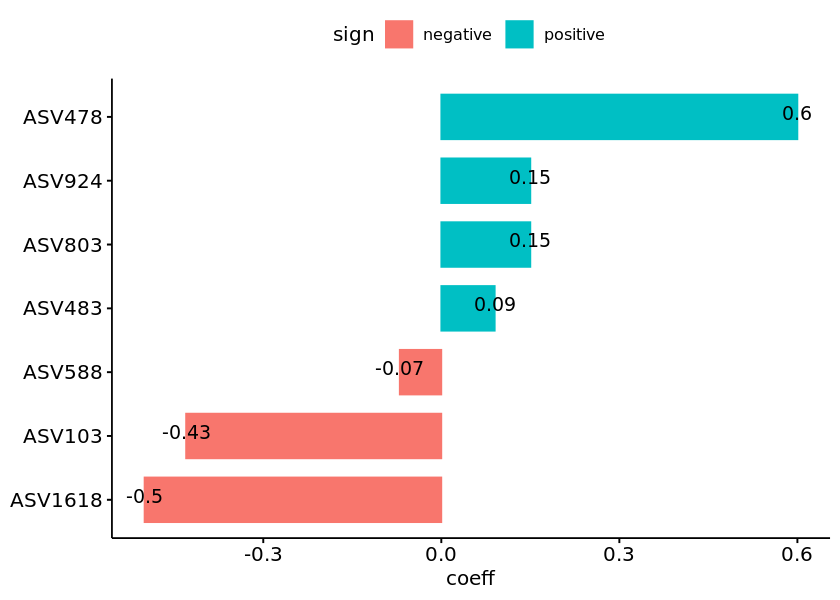

png 
  2

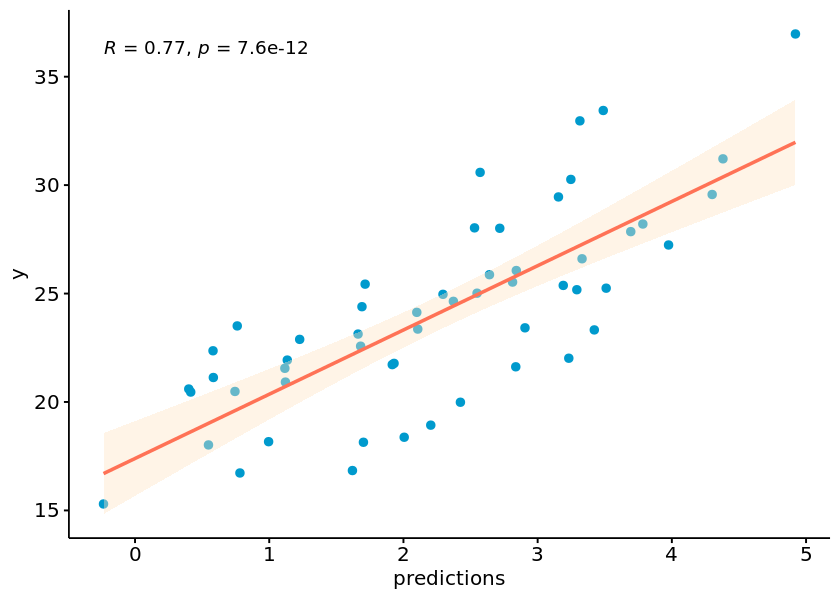

In [50]:
bal$`signature plot`
bal$`predictions plot`
pdf("img/volatility_microbial_signature.HUU.pdf")
bal$`signature plot`
bal$`predictions plot`
dev.off()

In [51]:
# taxa that are driving volatility in HEU?
glom <- ps.dat.L7
glom <- subset_samples(glom, hiv_status == "HEU")
glom <- filter_taxa(glom, function(x) sum(x > 500) > (0.01*length(x)), TRUE)
# pull data
dat <- as.data.frame(otu_table(glom))
map <- as.data.frame(as.matrix(sample_data(glom))) # have to coerce to data frame
map <- tibble::rownames_to_column(map) # retain rownames for downstream processing
# first need to get comparable variable to merge our data on
# head(dist_diff)
map$Var1 <- paste(map$study_id, map$FDI_code, sep=".")
# head(map)
# head(dist_diff)
# merge dist_diff with map
map <- merge(as.data.frame(map), dist_diff, by="Var1")
# merge new metadata with asv table so the response variable is in the same order
datmerge <- merge(dat, map, by.x = "row.names", by.y = "rowname")
datmerge <- datmerge[!duplicated(datmerge[c('Row.names')]), ]
row.names(datmerge) <- datmerge$Row.names
# define data and response variable
dif <- dim(datmerge)[2] - dim(map)[2]
x <- datmerge[,2:dif]
# make sure only numeric data
# x <- select_if(x, is.numeric)
# dim(x)
x <- as.matrix(x) # ASV abundance table
x_time <- as.numeric(datmerge$visit_num) # time point
subject_id <- datmerge$study_id # subject id
y <- datmerge$value # response value (here is volatility)
ini_time <- 1
end_time <- 3
set.seed(852)
bal <- coda_glmnet_longitudinal(x, y, x_time, subject_id, ini_time, end_time, nfolds=10, showPlots = FALSE)

[1] "ind= 1"
[1] "ind= 2"
[1] "ind= 3"
[1] "ind= 4"
[1] "ind= 5"
[1] "ind= 6"
[1] "ind= 7"
[1] "ind= 8"
[1] "ind= 9"
[1] "ind= 10"
[1] "ind= 11"
[1] "ind= 12"
[1] "ind= 13"
[1] "ind= 14"
[1] "ind= 15"
[1] "ind= 16"
[1] "ind= 17"
[1] "ind= 18"
[1] "ind= 19"
[1] "ind= 20"
[1] "ind= 21"
[1] "ind= 22"
[1] "ind= 23"
[1] "ind= 24"
[1] "ind= 25"
[1] "ind= 26"
[1] "ind= 27"
[1] "ind= 28"
[1] "ind= 29"
[1] "ind= 30"
[1] "ind= 31"
[1] "ind= 32"
[1] "ind= 33"
[1] "ind= 34"
[1] "ind= 35"
[1] "ind= 36"
[1] "ind= 37"
[1] "ind= 38"
[1] "ind= 39"
[1] "ind= 40"
[1] "ind= 41"
[1] "ind= 42"
[1] "ind= 43"
[1] "ind= 44"
[1] "ind= 45"
[1] "ind= 46"
[1] "ind= 47"
[1] "ind= 48"
[1] "ind= 49"
[1] "ind= 50"
[1] "ind= 51"
[1] "ind= 52"
[1] "ind= 53"
[1] "ind= 54"
[1] "ind= 55"
[1] "ind= 56"
[1] "ind= 57"
[1] "ind= 58"
[1] "ind= 59"
[1] "ind= 60"
[1] "ind= 61"
[1] "ind= 62"
[1] "ind= 63"
[1] "ind= 64"
[1] "ind= 65"
[1] "ind= 66"
[1] "ind= 67"
[1] "ind= 68"
[1] "ind= 69"
[1] "ind= 70"
[1] "ind= 71"
[1] "ind= 72"
[

Warning message in cor(predictions, y_unique):
“the standard deviation is zero”
Warning message in max(.):
“no non-missing arguments to max; returning -Inf”


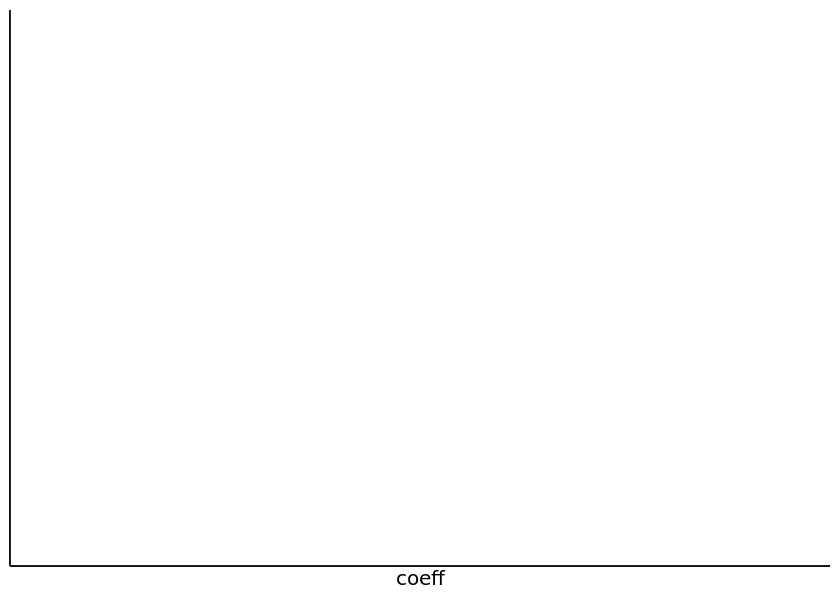

png 
  2

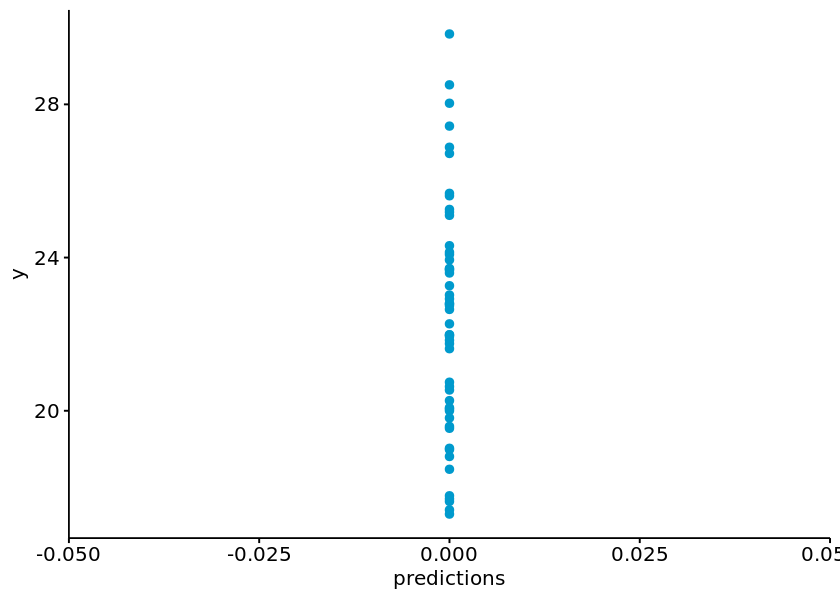

In [52]:
bal$`signature plot`
bal$`predictions plot`
pdf("img/volatility_microbial_signature.HEU.pdf")
bal$`signature plot`
bal$`predictions plot`
dev.off()